<a href="https://colab.research.google.com/github/hmaldonado12/7506R-1C2024-GRUPO6/blob/main/tp2/TensorFlow_7506R_TP2_GRUPO06_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
np.random.seed(1)
tf.random.set_seed(1)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df_train_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df_test_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

df_train = df_train_original.copy()
df_test = df_test_original.copy()

# Preprocesamiento del dataset.

En esta notebook nos encargamos de efectuar la limpieza de dataset, la detección de datos incorrectos y/o vacíos, outliers, todo aquello que pueda imposibilitarnos a usar los modelos propuestos.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Podemos ver que el dataset train no tiene datos faltantes.

In [7]:
df_train[df_train.duplicated(keep=False)]

,ID,review_es,sentimiento


Tampoco tiene filas duplicadas.

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


In [9]:
df_test[df_test.duplicated(keep=False)]

,ID,review_es


El mismo resultado para test.

# Bag of words

In [10]:
def preprocess_text(text):
    # tokenizacion
    tokens = word_tokenize(text.lower())
    # elimino signos de puntuación
    tokens = [word for word in tokens if word not in string.punctuation]
    # elimino stopwords
    stop_words = set(stopwords.words('spanish'))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df_train['review_es'] = df_train['review_es'].apply(preprocess_text)
df_test['review_es'] = df_test['review_es'].apply(preprocess_text)

In [31]:
max_features_d = 8599
count_vect = CountVectorizer(min_df=5, max_features=max_features_d)

xtrain = count_vect.fit_transform(df_train['review_es'])
xtest = count_vect.transform(df_test['review_es'])

In [32]:
X_train, X_val, Y_train, Y_val = train_test_split(xtrain, df_train['sentimiento'], test_size=0.2, random_state=42)
X_test =xtest.copy()

Modifico el texto de Y_train e Y_val para que sean enteros.

In [33]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)

# TensorFlow + Keras


In [35]:
modelo = keras.Sequential([
    keras.layers.Dense(1,input_shape=(X_train.shape[1],)),
    keras.layers.Dense(1, activation='sigmoid')])

modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 8600      
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 8,602
Trainable params: 8,602
Non-trainable params: 0
_________________________________________________________________


In [46]:
modelo.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01),
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['AUC'],
)

cant_epochs=100
modelo_historia = modelo.fit(pd.DataFrame.sparse.from_spmatrix(X_train), np.ravel(Y_train_encoded),
                                                epochs=cant_epochs,
                                                batch_size=50,verbose=False)

In [47]:
y_predic = modelo.predict(pd.DataFrame.sparse.from_spmatrix(X_val))
y_predic_cat = np.where(y_predic > 0.5, 1, 0)


313/313 [==============================] - 2s 6ms/step


In [48]:
y_val_pred_labels = label_encoder.inverse_transform(y_predic_cat)
y_val_true_labels = label_encoder.inverse_transform(Y_val_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_val_true_labels, y_val_pred_labels))
print("Precision:", precision_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print("Recall:", recall_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print("F1 Score:", f1_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))

print("Classification Report:\n", classification_report(y_val_true_labels, y_val_pred_labels))

Accuracy: 0.848
Precision: 0.8523933506909673
Recall: 0.8446120261956738
F1 Score: 0.8484848484848485
Classification Report:
               precision    recall  f1-score   support

    negativo       0.84      0.85      0.85      4961
    positivo       0.85      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



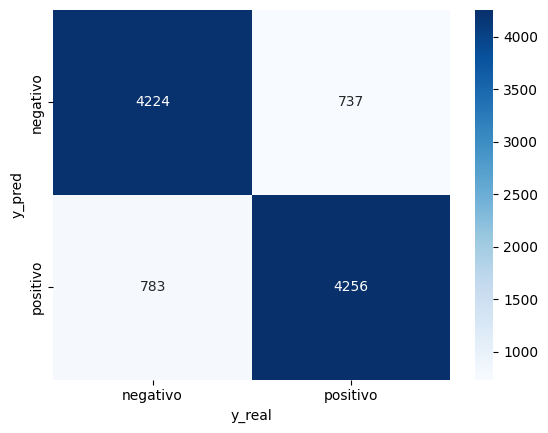

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

ds_validacion = pd.DataFrame(y_val_pred_labels,y_val_true_labels).reset_index()
ds_validacion.columns = ['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues',fmt='g')
plt.show()

In [52]:
y_predic_test = modelo.predict(pd.DataFrame.sparse.from_spmatrix(X_test))
y_predic_cat_test = np.where(y_predic_test > 0.5, 1, 0)

269/269 [==============================] - 1s 4ms/step


In [53]:
y_val_pred_labels = label_encoder.inverse_transform(y_predic_cat_test)
y_val_pred_labels

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['negativo', 'positivo', 'negativo', ..., 'positivo', 'negativo',
       'negativo'], dtype=object)

In [55]:
submit = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': y_val_pred_labels})
submit

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


Lo guardo para subirlo a Kaggle.

In [56]:
submit.to_csv('/content/drive/My Drive/Colab Notebooks/TensorFlow.csv', index=False)

In [57]:
submit

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo
